In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost
from math import log, ceil 
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

# Load data

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

df = pd.read_csv('credit_risk_dataset.csv')
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [3]:
target = 'loan_status'

continuous_features = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
cat_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

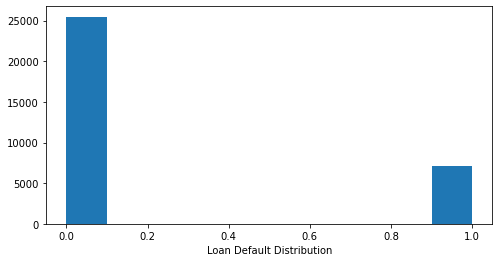

In [4]:
fig = plt.figure(figsize=(8,4))
plt.xlabel('Loan Default Distribution')
plt.hist(df[target]);

In [5]:
print('Number of rows:', df.shape[0])
print('Number of columns:', df.shape[1])

Number of rows: 32581
Number of columns: 12


In [6]:
df.duplicated().sum()

165

Drop duplicated data

In [7]:
df.drop_duplicates(keep='last', inplace=True)

In [8]:
# Nan Percentage by Column
list_column_nan = df[df.columns[df.isnull().any()]].isnull().sum() * 100 / df.shape[0]
list_column_nan

person_emp_length    2.736303
loan_int_rate        9.547754
dtype: float64

There are missing values, but it's okay since we will use WOE

## Descriptive Statistics

In [9]:
pd.options.display.max_rows = 1000
df.describe(include='number').transpose().apply(lambda s: s.apply('{0:.2f}'.format)).T

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32416.00,32416.00,31529.00,32416.00,29321.00,32416.00,32416.00,32416.00
mean,27.75,66091.64,4.79,9593.85,11.02,0.22,0.17,5.81
std,6.35,62015.58,4.15,6322.73,3.24,0.41,0.11,4.06
min,20.00,4000.00,0.00,500.00,5.42,0.00,0.00,2.00
25%,23.00,38542.00,2.00,5000.00,7.90,0.00,0.09,3.00
50%,26.00,55000.00,4.00,8000.00,10.99,0.00,0.15,4.00
75%,30.00,79218.00,7.00,12250.00,13.47,0.00,0.23,8.00
max,144.00,6000000.00,123.00,35000.00,23.22,1.00,0.83,30.00


There's outlier in the data, but we will ignore it for now

In [10]:
pd.options.display.max_rows = 1000
df.describe(include='object')

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
count,32416,32416,32416,32416
unique,4,6,7,2
top,RENT,EDUCATION,A,N
freq,16378,6411,10703,26686


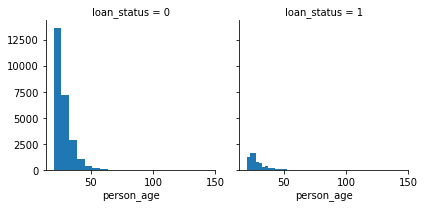

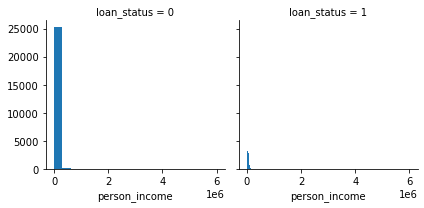

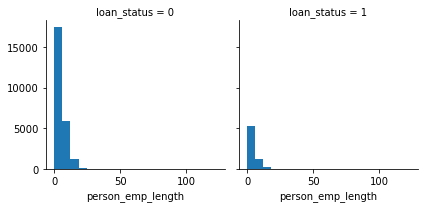

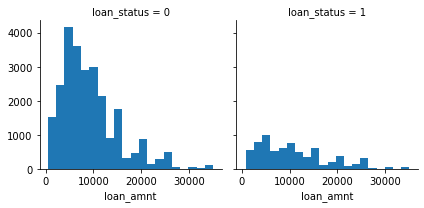

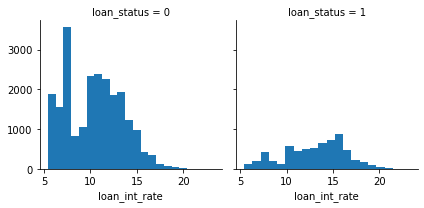

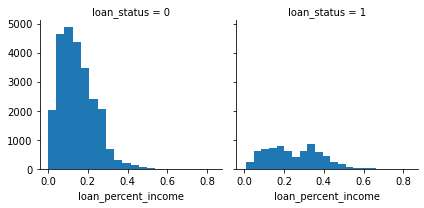

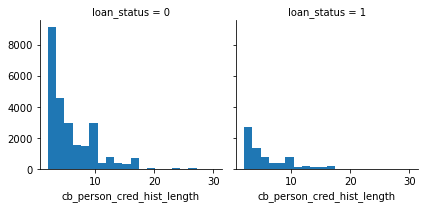

In [11]:
for i in continuous_features:
    g = sns.FacetGrid(df[df[target].notnull()], col=target)
    g.map(plt.hist, i, bins=20)

# Splitting Data

In [12]:
# Creating holdout sample 20% from total data
holdout = df.sample(frac=0.2, random_state=42)

# Drop holdout sample from dataframe to avoid leakage
df.drop(holdout.index, inplace=True)

# Train test split before feature engineering/preprocessing to avoid leakage
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'loan_status'], df['loan_status'], test_size=0.2, random_state=42)

# Feature Transformation

In [13]:
X_train = pd.concat([X_train,pd.get_dummies(X_train[cat_features],
                               drop_first=True)], axis=1).reset_index(drop=True)

X_test = pd.concat([X_test,pd.get_dummies(X_test[cat_features],
                               drop_first=True)], axis=1).reset_index(drop=True)

In [14]:
holdout = pd.concat([holdout,pd.get_dummies(holdout[cat_features],
                               drop_first=True)], axis=1).reset_index(drop=True)

In [15]:
X_train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y
0,24,67000,MORTGAGE,2.0,HOMEIMPROVEMENT,B,12150,10.37,0.18,N,3,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
1,22,72000,MORTGAGE,6.0,EDUCATION,E,8000,16.45,0.11,N,4,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
2,22,35000,RENT,2.0,MEDICAL,F,7000,18.09,0.20,Y,2,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1
3,35,28080,RENT,3.0,MEDICAL,C,9600,13.57,0.34,Y,7,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1
4,22,32000,RENT,0.0,PERSONAL,D,7875,14.91,0.25,N,2,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0


## Weight of Evidence

### Age

In [16]:
feature = 'person_age'
binning=[-float("inf"), 21, float("inf")]

bin_feature = pd.cut(X_train[feature], bins=binning).values.add_categories('Nan').fillna('Nan')
data_woe_iv = (pd.crosstab(bin_feature, y_train,normalize='columns')
             .assign(woe=lambda datax: np.log(datax[1] / datax[0]))
             .assign(iv=lambda datax: np.sum(datax['woe']*
                                           (datax[1]-datax[0]))))

data_woe_iv

loan_status,0,1,woe,iv
row_0,,,,
"(-inf, 21.0]",0.033263,0.049317,0.393821,0.006591
"(21.0, inf]",0.966737,0.950683,-0.016746,0.006591


In [17]:
X_train[f'{feature}_WOE'] = pd.cut(X_train[feature], bins=binning, labels=[0.393821, -0.016746])
X_train[f'{feature}_WOE'] = X_train[f'{feature}_WOE'].values.add_categories('Nan').fillna('Nan') 
X_train[f'{feature}_WOE'] = X_train[f'{feature}_WOE'].replace('Nan', 0)
X_train[f'{feature}_WOE'] = X_train[f'{feature}_WOE'].astype(float)

In [18]:
feature = 'person_age'
binning=[-float("inf"), 21, float("inf")]

bin_feature = pd.cut(X_test[feature], bins=binning).values.add_categories('Nan').fillna('Nan')
data_woe_iv = (pd.crosstab(bin_feature, y_test,normalize='columns')
             .assign(woe=lambda datax: np.log(datax[1] / datax[0]))
             .assign(iv=lambda datax: np.sum(datax['woe']*
                                           (datax[1]-datax[0]))))

data_woe_iv

loan_status,0,1,woe,iv
row_0,,,,
"(-inf, 21.0]",0.03567,0.052174,0.380271,0.006561
"(21.0, inf]",0.96433,0.947826,-0.017262,0.006561


In [19]:
X_test[f'{feature}_WOE'] = pd.cut(X_test[feature], bins=binning, labels=[0.380271, -0.017262])
X_test[f'{feature}_WOE'] = X_test[f'{feature}_WOE'].values.add_categories('Nan').fillna('Nan') 
X_test[f'{feature}_WOE'] = X_test[f'{feature}_WOE'].replace('Nan', 0)
X_test[f'{feature}_WOE'] = X_test[f'{feature}_WOE'].astype(float)

In [20]:
feature = 'person_age'
binning=[-float("inf"), 21, float("inf")]

bin_feature = pd.cut(holdout[feature], bins=binning).values.add_categories('Nan').fillna('Nan')
data_woe_iv = (pd.crosstab(bin_feature, holdout[target],normalize='columns')
             .assign(woe=lambda datax: np.log(datax[1] / datax[0]))
             .assign(iv=lambda datax: np.sum(datax['woe']*
                                           (datax[1]-datax[0]))))

data_woe_iv

loan_status,0,1,woe,iv
row_0,,,,
"(-inf, 21.0]",0.034015,0.062992,0.616210,0.018739
"(21.0, inf]",0.965985,0.937008,-0.030457,0.018739


In [21]:
holdout[f'{feature}_WOE'] = pd.cut(holdout[feature], bins=binning, labels=[0.616210, -0.030457])
holdout[f'{feature}_WOE'] = holdout[f'{feature}_WOE'].values.add_categories('Nan').fillna('Nan') 
holdout[f'{feature}_WOE'] = holdout[f'{feature}_WOE'].replace('Nan', 0)
holdout[f'{feature}_WOE'] = holdout[f'{feature}_WOE'].astype(float)

### Person income

In [22]:
feature = 'person_income'
binning=[-float("inf"), 10000, 20000, 30000, 50000, 60000, 80000, float("inf")]

bin_feature = pd.cut(X_train[feature], bins=binning).values.add_categories('Nan').fillna('Nan')
data_woe_iv = (pd.crosstab(bin_feature, y_train,normalize='columns')
             .assign(woe=lambda datax: np.log(datax[1] / datax[0]))
             .assign(iv=lambda datax: np.sum(datax['woe']*
                                           (datax[1]-datax[0]))))

data_woe_iv

loan_status,0,1,woe,iv
row_0,,,,
"(-inf, 10000.0]",0.000494,0.010348,3.042597,0.493666
"(10000.0, 20000.0]",0.011232,0.110524,2.286484,0.493666
"(20000.0, 30000.0]",0.085843,0.160502,0.625786,0.493666
"(30000.0, 50000.0]",0.285547,0.344782,0.188507,0.493666
"(50000.0, 60000.0]",0.146692,0.129679,-0.123278,0.493666
"(60000.0, 80000.0]",0.203407,0.140026,-0.373376,0.493666
"(80000.0, inf]",0.266786,0.104139,-0.940719,0.493666


In [23]:
X_train[f'{feature}_WOE'] = pd.cut(X_train[feature], bins=binning, labels=[3.042597, 2.286484, 0.625786, 0.188507, -0.123278, -0.373376, -0.940719])
X_train[f'{feature}_WOE'] = X_train[f'{feature}_WOE'].values.add_categories('Nan').fillna('Nan') 
X_train[f'{feature}_WOE'] = X_train[f'{feature}_WOE'].replace('Nan', 0)
X_train[f'{feature}_WOE'] = X_train[f'{feature}_WOE'].astype(float)

In [24]:
feature = 'person_income'
binning=[-float("inf"), 10000, 20000, 30000, 50000, 60000, 80000, float("inf")]

bin_feature = pd.cut(X_test[feature], bins=binning).values.add_categories('Nan').fillna('Nan')
data_woe_iv = (pd.crosstab(bin_feature, y_test,normalize='columns')
             .assign(woe=lambda datax: np.log(datax[1] / datax[0]))
             .assign(iv=lambda datax: np.sum(datax['woe']*
                                           (datax[1]-datax[0]))))

data_woe_iv

loan_status,0,1,woe,iv
row_0,,,,
"(-inf, 10000.0]",0.000248,0.013043,3.963790,0.679747
"(10000.0, 20000.0]",0.008174,0.120000,2.686486,0.679747
"(20000.0, 30000.0]",0.087441,0.170435,0.667387,0.679747
"(30000.0, 50000.0]",0.261333,0.346087,0.280896,0.679747
"(50000.0, 60000.0]",0.154075,0.129565,-0.173254,0.679747
"(60000.0, 80000.0]",0.207332,0.126957,-0.490478,0.679747
"(80000.0, inf]",0.281397,0.093913,-1.097397,0.679747


In [25]:
X_test[f'{feature}_WOE'] = pd.cut(X_test[feature], bins=binning, labels=[3.963790, 2.686486, 0.667387, 0.280896, -0.173254, -0.490478, -1.097397])
X_test[f'{feature}_WOE'] = X_test[f'{feature}_WOE'].values.add_categories('Nan').fillna('Nan') 
X_test[f'{feature}_WOE'] = X_test[f'{feature}_WOE'].replace('Nan', 0)
X_test[f'{feature}_WOE'] = X_test[f'{feature}_WOE'].astype(float)

In [26]:
feature = 'person_income'
binning=[-float("inf"), 10000, 20000, 30000, 50000, 60000, 80000, float("inf")]

bin_feature = pd.cut(holdout[feature], bins=binning).values.add_categories('Nan').fillna('Nan')
data_woe_iv = (pd.crosstab(bin_feature, holdout[target],normalize='columns')
             .assign(woe=lambda datax: np.log(datax[1] / datax[0]))
             .assign(iv=lambda datax: np.sum(datax['woe']*
                                           (datax[1]-datax[0]))))

data_woe_iv

loan_status,0,1,woe,iv
row_0,,,,
"(-inf, 10000.0]",0.000786,0.011453,2.678459,0.591463
"(10000.0, 20000.0]",0.011011,0.114531,2.341987,0.591463
"(20000.0, 30000.0]",0.081203,0.173228,0.757655,0.591463
"(30000.0, 50000.0]",0.273299,0.341446,0.222622,0.591463
"(50000.0, 60000.0]",0.138812,0.128848,-0.074494,0.591463
"(60000.0, 80000.0]",0.211758,0.133142,-0.464023,0.591463
"(80000.0, inf]",0.283130,0.097351,-1.067579,0.591463


In [27]:
holdout[f'{feature}_WOE'] = pd.cut(holdout[feature], bins=binning, labels=[2.678459, 2.341987, 0.757655, 0.222622, -0.074494, -0.464023, -1.067579])
holdout[f'{feature}_WOE'] = holdout[f'{feature}_WOE'].values.add_categories('Nan').fillna('Nan') 
holdout[f'{feature}_WOE'] = holdout[f'{feature}_WOE'].replace('Nan', 0)
holdout[f'{feature}_WOE'] = holdout[f'{feature}_WOE'].astype(float)

### Employee length

In [28]:
feature = 'person_emp_length'
binning=[-float("inf"), 1, float("inf")]

bin_feature = pd.cut(X_train[feature], bins=binning).values.add_categories('Nan').fillna('Nan')
data_woe_iv = (pd.crosstab(bin_feature, y_train,normalize='columns')
             .assign(woe=lambda datax: np.log(datax[1] / datax[0]))
             .assign(iv=lambda datax: np.sum(datax['woe']*
                                           (datax[1]-datax[0]))))

data_woe_iv

loan_status,0,1,woe,iv
row_0,,,,
"(-inf, 1.0]",0.198099,0.277631,0.337525,0.045672
"(1.0, inf]",0.778511,0.684720,-0.128373,0.045672
Nan,0.023389,0.037649,0.476018,0.045672


In [29]:
X_train[f'{feature}_WOE'] = pd.cut(X_train[feature], bins=binning, labels=[0.337525, -0.128373])
X_train[f'{feature}_WOE'] = X_train[f'{feature}_WOE'].values.add_categories('Nan').fillna('Nan') 
X_train[f'{feature}_WOE'] = X_train[f'{feature}_WOE'].replace('Nan', 0.476018)
X_train[f'{feature}_WOE'] = X_train[f'{feature}_WOE'].astype(float)

In [30]:
feature = 'person_emp_length'
binning=[-float("inf"), 1, float("inf")]

bin_feature = pd.cut(X_test[feature], bins=binning).values.add_categories('Nan').fillna('Nan')
data_woe_iv = (pd.crosstab(bin_feature, y_test,normalize='columns')
             .assign(woe=lambda datax: np.log(datax[1] / datax[0]))
             .assign(iv=lambda datax: np.sum(datax['woe']*
                                           (datax[1]-datax[0]))))

data_woe_iv

loan_status,0,1,woe,iv
row_0,,,,
"(-inf, 1.0]",0.205846,0.255652,0.216690,0.037537
"(1.0, inf]",0.770374,0.694783,-0.103277,0.037537
Nan,0.023780,0.049565,0.734443,0.037537


In [31]:
X_test[f'{feature}_WOE'] = pd.cut(X_test[feature], bins=binning, labels=[0.216690, -0.103277])
X_test[f'{feature}_WOE'] = X_test[f'{feature}_WOE'].values.add_categories('Nan').fillna('Nan') 
X_test[f'{feature}_WOE'] = X_test[f'{feature}_WOE'].replace('Nan', 0.734443)
X_test[f'{feature}_WOE'] = X_test[f'{feature}_WOE'].astype(float)

In [32]:
feature = 'person_emp_length'
binning=[-float("inf"), 1, float("inf")]

bin_feature = pd.cut(holdout[feature], bins=binning).values.add_categories('Nan').fillna('Nan')
data_woe_iv = (pd.crosstab(bin_feature, holdout[target],normalize='columns')
             .assign(woe=lambda datax: np.log(datax[1] / datax[0]))
             .assign(iv=lambda datax: np.sum(datax['woe']*
                                           (datax[1]-datax[0]))))

data_woe_iv

loan_status,0,1,woe,iv
row_0,,,,
"(-inf, 1.0]",0.195832,0.279885,0.357125,0.047435
"(1.0, inf]",0.778411,0.682176,-0.131967,0.047435
Nan,0.025757,0.037938,0.387259,0.047435


In [33]:
holdout[f'{feature}_WOE'] = pd.cut(holdout[feature], bins=binning, labels=[0.357125, -0.131967])
holdout[f'{feature}_WOE'] = holdout[f'{feature}_WOE'].values.add_categories('Nan').fillna('Nan') 
holdout[f'{feature}_WOE'] = holdout[f'{feature}_WOE'].replace('Nan', 0.387259)
holdout[f'{feature}_WOE'] = holdout[f'{feature}_WOE'].astype(float)

### Loan amount

In [34]:
feature = 'loan_amnt'
binning=[-float("inf"), 10000, 15000, float("inf")]

bin_feature = pd.cut(X_train[feature], bins=binning).values.add_categories('Nan').fillna('Nan')
data_woe_iv = (pd.crosstab(bin_feature, y_train,normalize='columns')
             .assign(woe=lambda datax: np.log(datax[1] / datax[0]))
             .assign(iv=lambda datax: np.sum(datax['woe']*
                                           (datax[1]-datax[0]))))

data_woe_iv

loan_status,0,1,woe,iv
row_0,,,,
"(-inf, 10000.0]",0.688657,0.574857,-0.180622,0.078551
"(10000.0, 15000.0]",0.184090,0.199031,0.078035,0.078551
"(15000.0, inf]",0.127253,0.226112,0.574856,0.078551


In [35]:
X_train[f'{feature}_WOE'] = pd.cut(X_train[feature], bins=binning, labels=[-0.180622, 0.078035, 0.574856])
X_train[f'{feature}_WOE'] = X_train[f'{feature}_WOE'].values.add_categories('Nan').fillna('Nan') 
X_train[f'{feature}_WOE'] = X_train[f'{feature}_WOE'].replace('Nan', 0)
X_train[f'{feature}_WOE'] = X_train[f'{feature}_WOE'].astype(float)

In [36]:
feature = 'loan_amnt'
binning=[-float("inf"), 10000, 15000, float("inf")]

bin_feature = pd.cut(X_test[feature], bins=binning).values.add_categories('Nan').fillna('Nan')
data_woe_iv = (pd.crosstab(bin_feature, y_test,normalize='columns')
             .assign(woe=lambda datax: np.log(datax[1] / datax[0]))
             .assign(iv=lambda datax: np.sum(datax['woe']*
                                           (datax[1]-datax[0]))))

data_woe_iv

loan_status,0,1,woe,iv
row_0,,,,
"(-inf, 10000.0]",0.670547,0.586957,-0.133144,0.038574
"(10000.0, 15000.0]",0.186525,0.202609,0.082713,0.038574
"(15000.0, inf]",0.142928,0.210435,0.386835,0.038574


In [37]:
X_test[f'{feature}_WOE'] = pd.cut(X_test[feature], bins=binning, labels=[-0.133144, 0.082713, 0.386835])
X_test[f'{feature}_WOE'] = X_test[f'{feature}_WOE'].values.add_categories('Nan').fillna('Nan') 
X_test[f'{feature}_WOE'] = X_test[f'{feature}_WOE'].replace('Nan', 0)
X_test[f'{feature}_WOE'] = X_test[f'{feature}_WOE'].astype(float)

In [38]:
feature = 'loan_amnt'
binning=[-float("inf"), 10000, 15000, float("inf")]

bin_feature = pd.cut(holdout[feature], bins=binning).values.add_categories('Nan').fillna('Nan')
data_woe_iv = (pd.crosstab(bin_feature, holdout[target],normalize='columns')
             .assign(woe=lambda datax: np.log(datax[1] / datax[0]))
             .assign(iv=lambda datax: np.sum(datax['woe']*
                                           (datax[1]-datax[0]))))

data_woe_iv

loan_status,0,1,woe,iv
row_0,,,,
"(-inf, 10000.0]",0.679316,0.576951,-0.163329,0.069126
"(10000.0, 15000.0]",0.186591,0.192555,0.031467,0.069126
"(15000.0, inf]",0.134094,0.230494,0.541686,0.069126


In [39]:
holdout[f'{feature}_WOE'] = pd.cut(holdout[feature], bins=binning, labels=[-0.163329, 0.031467, 0.541686])
holdout[f'{feature}_WOE'] = holdout[f'{feature}_WOE'].values.add_categories('Nan').fillna('Nan') 
holdout[f'{feature}_WOE'] = holdout[f'{feature}_WOE'].replace('Nan', 0)
holdout[f'{feature}_WOE'] = holdout[f'{feature}_WOE'].astype(float)

### loan interest rate

In [40]:
feature = 'loan_int_rate'
binning=[-float("inf"), 15, float("inf")]

bin_feature = pd.cut(X_train[feature], bins=binning).values.add_categories('Nan').fillna('Nan')
data_woe_iv = (pd.crosstab(bin_feature, y_train,normalize='columns')
             .assign(woe=lambda datax: np.log(datax[1] / datax[0]))
             .assign(iv=lambda datax: np.sum(datax['woe']*
                                           (datax[1]-datax[0]))))

data_woe_iv

loan_status,0,1,woe,iv
row_0,,,,
"(-inf, 15.0]",0.847692,0.625055,-0.304678,0.431345
"(15.0, inf]",0.055974,0.281154,1.614017,0.431345
Nan,0.096334,0.093791,-0.026752,0.431345


In [41]:
X_train[f'{feature}_WOE'] = pd.cut(X_train[feature], bins=binning, labels=[-0.304678, 1.614017])
X_train[f'{feature}_WOE'] = X_train[f'{feature}_WOE'].values.add_categories('Nan').fillna('Nan') 
X_train[f'{feature}_WOE'] = X_train[f'{feature}_WOE'].replace('Nan', -0.02675)
X_train[f'{feature}_WOE'] = X_train[f'{feature}_WOE'].astype(float)

In [42]:
feature = 'loan_int_rate'
binning=[-float("inf"), 15, float("inf")]

bin_feature = pd.cut(X_test[feature], bins=binning).values.add_categories('Nan').fillna('Nan')
data_woe_iv = (pd.crosstab(bin_feature, y_test,normalize='columns')
             .assign(woe=lambda datax: np.log(datax[1] / datax[0]))
             .assign(iv=lambda datax: np.sum(datax['woe']*
                                           (datax[1]-datax[0]))))

data_woe_iv

loan_status,0,1,woe,iv
row_0,,,,
"(-inf, 15.0]",0.848155,0.653913,-0.260089,0.375268
"(15.0, inf]",0.055734,0.263478,1.553372,0.375268
Nan,0.096111,0.082609,-0.151389,0.375268


In [43]:
X_test[f'{feature}_WOE'] = pd.cut(X_test[feature], bins=binning, labels=[-0.260089, 1.553372])
X_test[f'{feature}_WOE'] = X_test[f'{feature}_WOE'].values.add_categories('Nan').fillna('Nan') 
X_test[f'{feature}_WOE'] = X_test[f'{feature}_WOE'].replace('Nan', -0.151389)
X_test[f'{feature}_WOE'] = X_test[f'{feature}_WOE'].astype(float)

In [44]:
feature = 'loan_int_rate'
binning=[-float("inf"), 15, float("inf")]

bin_feature = pd.cut(holdout[feature], bins=binning).values.add_categories('Nan').fillna('Nan')
data_woe_iv = (pd.crosstab(bin_feature, holdout[target],normalize='columns')
             .assign(woe=lambda datax: np.log(datax[1] / datax[0]))
             .assign(iv=lambda datax: np.sum(datax['woe']*
                                           (datax[1]-datax[0]))))

data_woe_iv

loan_status,0,1,woe,iv
row_0,,,,
"(-inf, 15.0]",0.840346,0.617752,-0.307726,0.445938
"(15.0, inf]",0.060362,0.296349,1.591183,0.445938
Nan,0.099292,0.085898,-0.144902,0.445938


In [45]:
holdout[f'{feature}_WOE'] = pd.cut(holdout[feature], bins=binning, labels=[-0.307726, 1.591183])
holdout[f'{feature}_WOE'] = holdout[f'{feature}_WOE'].values.add_categories('Nan').fillna('Nan') 
holdout[f'{feature}_WOE'] = holdout[f'{feature}_WOE'].replace('Nan', -0.144902)
holdout[f'{feature}_WOE'] = holdout[f'{feature}_WOE'].astype(float)

### Loan percent income

In [46]:
feature = 'loan_percent_income'
binning=[-float("inf"), 0.2, 0.3, float("inf")]

bin_feature = pd.cut(X_train[feature], bins=binning).values.add_categories('Nan').fillna('Nan')
data_woe_iv = (pd.crosstab(bin_feature, y_train,normalize='columns')
             .assign(woe=lambda datax: np.log(datax[1] / datax[0]))
             .assign(iv=lambda datax: np.sum(datax['woe']*
                                           (datax[1]-datax[0]))))

data_woe_iv

loan_status,0,1,woe,iv
row_0,,,,
"(-inf, 0.2]",0.765552,0.426684,-0.584552,0.905535
"(0.2, 0.3]",0.191187,0.201453,0.052303,0.905535
"(0.3, inf]",0.043261,0.371863,2.151275,0.905535


In [47]:
X_train[f'{feature}_WOE'] = pd.cut(X_train[feature], bins=binning, labels=[-0.584552, 0.052303, 2.151275])
X_train[f'{feature}_WOE'] = X_train[f'{feature}_WOE'].values.add_categories('Nan').fillna('Nan') 
X_train[f'{feature}_WOE'] = X_train[f'{feature}_WOE'].replace('Nan', 0)
X_train[f'{feature}_WOE'] = X_train[f'{feature}_WOE'].astype(float)

In [48]:
feature = 'loan_percent_income'
binning=[-float("inf"), 0.2, 0.3, float("inf")]

bin_feature = pd.cut(X_test[feature], bins=binning).values.add_categories('Nan').fillna('Nan')
data_woe_iv = (pd.crosstab(bin_feature, y_test,normalize='columns')
             .assign(woe=lambda datax: np.log(datax[1] / datax[0]))
             .assign(iv=lambda datax: np.sum(datax['woe']*
                                           (datax[1]-datax[0]))))

data_woe_iv

loan_status,0,1,woe,iv
row_0,,,,
"(-inf, 0.2]",0.762200,0.441739,-0.545489,0.933886
"(0.2, 0.3]",0.193708,0.167826,-0.143425,0.933886
"(0.3, inf]",0.044092,0.390435,2.180979,0.933886


In [49]:
X_test[f'{feature}_WOE'] = pd.cut(X_test[feature], bins=binning, labels=[-0.545489, -0.143425, 2.180979])
X_test[f'{feature}_WOE'] = X_test[f'{feature}_WOE'].values.add_categories('Nan').fillna('Nan') 
X_test[f'{feature}_WOE'] = X_test[f'{feature}_WOE'].replace('Nan', 0)
X_test[f'{feature}_WOE'] = X_test[f'{feature}_WOE'].astype(float)

In [50]:
feature = 'loan_percent_income'
binning=[-float("inf"), 0.2, 0.3, float("inf")]

bin_feature = pd.cut(holdout[feature], bins=binning).values.add_categories('Nan').fillna('Nan')
data_woe_iv = (pd.crosstab(bin_feature, holdout[target],normalize='columns')
             .assign(woe=lambda datax: np.log(datax[1] / datax[0]))
             .assign(iv=lambda datax: np.sum(datax['woe']*
                                           (datax[1]-datax[0]))))

data_woe_iv

loan_status,0,1,woe,iv
row_0,,,,
"(-inf, 0.2]",0.767991,0.425913,-0.589543,0.922859
"(0.2, 0.3]",0.182855,0.178955,-0.021559,0.922859
"(0.3, inf]",0.049155,0.395132,2.084252,0.922859


In [51]:
holdout[f'{feature}_WOE'] = pd.cut(holdout[feature], bins=binning, labels=[-0.589543, -0.021559, 2.084252])
holdout[f'{feature}_WOE'] = holdout[f'{feature}_WOE'].values.add_categories('Nan').fillna('Nan') 
holdout[f'{feature}_WOE'] = holdout[f'{feature}_WOE'].replace('Nan', 0)
holdout[f'{feature}_WOE'] = holdout[f'{feature}_WOE'].astype(float)

### credit history length

In [52]:
feature = 'cb_person_cred_hist_length'
binning=[-float("inf"), 5, 10, float("inf")]

bin_feature = pd.cut(X_train[feature], bins=binning).values.add_categories('Nan').fillna('Nan')
data_woe_iv = (pd.crosstab(bin_feature, y_train,normalize='columns')
             .assign(woe=lambda datax: np.log(datax[1] / datax[0]))
             .assign(iv=lambda datax: np.sum(datax['woe']*
                                           (datax[1]-datax[0]))))

data_woe_iv

loan_status,0,1,woe,iv
row_0,,,,
"(-inf, 5.0]",0.595470,0.625716,0.049544,0.003854
"(5.0, 10.0]",0.295853,0.274328,-0.075536,0.003854
"(10.0, inf]",0.108677,0.099956,-0.083649,0.003854


In [53]:
X_train[f'{feature}_WOE'] = pd.cut(X_train[feature], bins=binning, labels=[0.049544, -0.075536, -0.083649])
X_train[f'{feature}_WOE'] = X_train[f'{feature}_WOE'].values.add_categories('Nan').fillna('Nan') 
X_train[f'{feature}_WOE'] = X_train[f'{feature}_WOE'].replace('Nan', 0)
X_train[f'{feature}_WOE'] = X_train[f'{feature}_WOE'].astype(float)

In [54]:
feature = 'cb_person_cred_hist_length'
binning=[-float("inf"), 5, 25, float("inf")]

bin_feature = pd.cut(X_test[feature], bins=binning).values.add_categories('Nan').fillna('Nan')
data_woe_iv = (pd.crosstab(bin_feature, y_test,normalize='columns')
             .assign(woe=lambda datax: np.log(datax[1] / datax[0]))
             .assign(iv=lambda datax: np.sum(datax['woe']*
                                           (datax[1]-datax[0]))))

data_woe_iv

loan_status,0,1,woe,iv
row_0,,,,
"(-inf, 5.0]",0.605895,0.616522,0.017386,0.001314
"(5.0, 25.0]",0.390884,0.381739,-0.023674,0.001314
"(25.0, inf]",0.003220,0.001739,-0.616062,0.001314


In [55]:
X_test[f'{feature}_WOE'] = pd.cut(X_test[feature], bins=binning, labels=[0.017386, -0.023674, -0.616062])
X_test[f'{feature}_WOE'] = X_test[f'{feature}_WOE'].values.add_categories('Nan').fillna('Nan') 
X_test[f'{feature}_WOE'] = X_test[f'{feature}_WOE'].replace('Nan', 0)
X_test[f'{feature}_WOE'] = X_test[f'{feature}_WOE'].astype(float)

In [56]:
feature = 'cb_person_cred_hist_length'
binning=[-float("inf"), 5, 10, float("inf")]

bin_feature = pd.cut(holdout[feature], bins=binning).values.add_categories('Nan').fillna('Nan')
data_woe_iv = (pd.crosstab(bin_feature, holdout[target],normalize='columns')
             .assign(woe=lambda datax: np.log(datax[1] / datax[0]))
             .assign(iv=lambda datax: np.sum(datax['woe']*
                                           (datax[1]-datax[0]))))

data_woe_iv

loan_status,0,1,woe,iv
row_0,,,,
"(-inf, 5.0]",0.602241,0.627774,0.041521,0.003229
"(5.0, 10.0]",0.290798,0.266285,-0.088063,0.003229
"(10.0, inf]",0.106960,0.105941,-0.009572,0.003229


In [57]:
holdout[f'{feature}_WOE'] = pd.cut(holdout[feature], bins=binning, labels=[0.041521, -0.088063, -0.009572])
holdout[f'{feature}_WOE'] = holdout[f'{feature}_WOE'].values.add_categories('Nan').fillna('Nan') 
holdout[f'{feature}_WOE'] = holdout[f'{feature}_WOE'].replace('Nan', 0)
holdout[f'{feature}_WOE'] = holdout[f'{feature}_WOE'].astype(float)

### Categorical WOE

### person_home_ownership

In [59]:
feature = 'person_home_ownership'
data_woe_iv = (pd.crosstab(X_train[feature], y_train,
                      normalize='columns')
             .assign(woe=lambda datax: np.log(datax[1] / datax[0]))
             .assign(iv=lambda datax: np.sum(datax['woe']*
                                           (datax[1]-datax[0]))))

data_woe_iv

loan_status,0,1,woe,iv
person_home_ownership,,,,
MORTGAGE,0.424758,0.387448,-0.091939,0.005886
OTHER,0.003486,0.004163,0.177484,0.005886
OWN,0.076287,0.079091,0.036089,0.005886
RENT,0.495469,0.529299,0.066049,0.005886


In [64]:
X_train['person_home_ownership_WOE'] = np.where(X_train['person_home_ownership'].isin(['MORTGAGE']), -0.091939, 
                  np.where(X_train['person_home_ownership'].isin(['OTHER']), 0.177484,
                  np.where(X_train['person_home_ownership'].isin(['OWN']), 0.036089,
                  np.where(X_train['person_home_ownership'].isin(['RENT']), 0.066049, 0))))

X_train['person_home_ownership'] = X_train['person_home_ownership'].fillna(value=0)

In [69]:
feature = 'person_home_ownership'
data_woe_iv = (pd.crosstab(X_test[feature], y_test,
                      normalize='columns')
             .assign(woe=lambda datax: np.log(datax[1] / datax[0]))
             .assign(iv=lambda datax: np.sum(datax['woe']*
                                           (datax[1]-datax[0]))))

data_woe_iv

loan_status,0,1,woe,iv
person_home_ownership,,,,
MORTGAGE,0.393836,0.372549,-0.055565,0.013813
OTHER,0.005137,0.003922,-0.269975,0.013813
OWN,0.063356,0.094118,0.395773,0.013813
RENT,0.537671,0.529412,-0.015481,0.013813


In [70]:
X_test['person_home_ownership_WOE'] = np.where(X_test['person_home_ownership'].isin(['MORTGAGE']), -0.044303, 
                  np.where(X_test['person_home_ownership'].isin(['OTHER']), 1.521785,
                  np.where(X_test['person_home_ownership'].isin(['OWN']), 0.304113,
                  np.where(X_test['person_home_ownership'].isin(['RENT']), -0.036781, 0))))

X_test['person_home_ownership'] = X_test['person_home_ownership'].fillna(value=0)

In [71]:
feature = 'person_home_ownership'
data_woe_iv = (pd.crosstab(holdout[feature], holdout[target],
                      normalize='columns')
             .assign(woe=lambda datax: np.log(datax[1] / datax[0]))
             .assign(iv=lambda datax: np.sum(datax['woe']*
                                           (datax[1]-datax[0]))))

data_woe_iv

loan_status,0,1,woe,iv
person_home_ownership,,,,
MORTGAGE,0.460283,0.230494,-0.691617,0.41779
OTHER,0.002556,0.002147,-0.174172,0.41779
OWN,0.100275,0.026485,-1.331328,0.41779
RENT,0.436886,0.740873,0.528158,0.41779


In [72]:
holdout['person_home_ownership_WOE'] = np.where(holdout['person_home_ownership'].isin(['MORTGAGE']), -0.691617, 
                  np.where(holdout['person_home_ownership'].isin(['OTHER']), -0.174172,
                  np.where(holdout['person_home_ownership'].isin(['OWN']), -1.331328,
                  np.where(holdout['person_home_ownership'].isin(['RENT']), 0.528158, 0))))

holdout['person_home_ownership'] = holdout['person_home_ownership'].fillna(value=0)

### Loan intent

In [73]:
feature = 'loan_intent'
data_woe_iv = (pd.crosstab(X_train[feature], y_train,
                      normalize='columns')
             .assign(woe=lambda datax: np.log(datax[1] / datax[0]))
             .assign(iv=lambda datax: np.sum(datax['woe']*
                                           (datax[1]-datax[0]))))

data_woe_iv

loan_status,0,1,woe,iv
loan_intent,,,,
DEBTCONSOLIDATION,0.166617,0.160423,-0.037885,0.002895
EDUCATION,0.195698,0.198207,0.012740,0.002895
HOMEIMPROVEMENT,0.109451,0.095421,-0.137180,0.002895
MEDICAL,0.188527,0.192443,0.020559,0.002895
PERSONAL,0.164326,0.168428,0.024653,0.002895
VENTURE,0.175381,0.185078,0.053819,0.002895


In [74]:
X_train['loan_intent_WOE'] = np.where(X_train['loan_intent'].isin(['DEBTCONSOLIDATION']), -0.037885, 
                  np.where(X_train['loan_intent'].isin(['EDUCATION']), 0.012740,
                  np.where(X_train['loan_intent'].isin(['HOMEIMPROVEMENT']), -0.137180,
                  np.where(X_train['loan_intent'].isin(['MEDICAL']), 0.020559,
                  np.where(X_train['loan_intent'].isin(['PERSONAL']), 0.024653, 
                  np.where(X_train['loan_intent'].isin(['VENTURE']), 0.053819, 0))))))

X_train['loan_intent'] = X_train['loan_intent'].fillna(value=0)

In [75]:
feature = 'loan_intent'
data_woe_iv = (pd.crosstab(X_test[feature], y_test,
                      normalize='columns')
             .assign(woe=lambda datax: np.log(datax[1] / datax[0]))
             .assign(iv=lambda datax: np.sum(datax['woe']*
                                           (datax[1]-datax[0]))))

data_woe_iv

loan_status,0,1,woe,iv
loan_intent,,,,
DEBTCONSOLIDATION,0.176370,0.145098,-0.195174,0.00892
EDUCATION,0.203767,0.200000,-0.018660,0.00892
HOMEIMPROVEMENT,0.135274,0.141176,0.042709,0.00892
MEDICAL,0.152397,0.152941,0.003563,0.00892
PERSONAL,0.172945,0.184314,0.063665,0.00892
VENTURE,0.159247,0.176471,0.102700,0.00892


In [76]:
X_test['loan_intent_WOE'] = np.where(X_test['loan_intent'].isin(['DEBTCONSOLIDATION']), -0.195174, 
                  np.where(X_test['loan_intent'].isin(['EDUCATION']), -0.018660,
                  np.where(X_test['loan_intent'].isin(['HOMEIMPROVEMENT']), 0.042709,
                  np.where(X_test['loan_intent'].isin(['MEDICAL']), 0.003563,
                  np.where(X_test['loan_intent'].isin(['PERSONAL']), 0.063665, 
                  np.where(X_test['loan_intent'].isin(['VENTURE']), 0.102700, 0))))))

X_test['loan_intent'] = X_test['loan_intent'].fillna(value=0)

In [77]:
feature = 'loan_intent'
data_woe_iv = (pd.crosstab(holdout[feature], holdout[target],
                      normalize='columns')
             .assign(woe=lambda datax: np.log(datax[1] / datax[0]))
             .assign(iv=lambda datax: np.sum(datax['woe']*
                                           (datax[1]-datax[0]))))

data_woe_iv

loan_status,0,1,woe,iv
loan_intent,,,,
DEBTCONSOLIDATION,0.142155,0.205440,0.368238,0.076327
EDUCATION,0.208612,0.167502,-0.219481,0.076327
HOMEIMPROVEMENT,0.114628,0.134574,0.160419,0.076327
MEDICAL,0.173614,0.216893,0.222572,0.076327
PERSONAL,0.172827,0.153901,-0.115982,0.076327
VENTURE,0.188164,0.121689,-0.435840,0.076327


In [78]:
holdout['loan_intent_WOE'] = np.where(holdout['loan_intent'].isin(['DEBTCONSOLIDATION']), 0.368238, 
                  np.where(holdout['loan_intent'].isin(['EDUCATION']), -0.219481,
                  np.where(holdout['loan_intent'].isin(['HOMEIMPROVEMENT']), 0.160419,
                  np.where(holdout['loan_intent'].isin(['MEDICAL']), 0.222572,
                  np.where(holdout['loan_intent'].isin(['PERSONAL']), -0.115982, 
                  np.where(holdout['loan_intent'].isin(['VENTURE']), -0.435840, 0))))))

holdout['loan_intent'] = holdout['loan_intent'].fillna(value=0)

### Loan Grade

In [79]:
feature = 'loan_grade'
data_woe_iv = (pd.crosstab(X_train[feature], y_train,
                      normalize='columns')
             .assign(woe=lambda datax: np.log(datax[1] / datax[0]))
             .assign(iv=lambda datax: np.sum(datax['woe']*
                                           (datax[1]-datax[0]))))

data_woe_iv

loan_status,0,1,woe,iv
loan_grade,,,,
A,0.330146,0.314761,-0.047721,0.003328
B,0.325266,0.330772,0.016784,0.003328
C,0.194503,0.200128,0.028512,0.003328
D,0.113037,0.114954,0.016817,0.003328
E,0.028384,0.029139,0.026253,0.003328
F,0.007370,0.006724,-0.091660,0.003328
G,0.001295,0.003522,1.000829,0.003328


In [80]:
X_train['loan_grade_WOE'] = np.where(X_train['loan_grade'].isin(['A']), -0.047721, 
                  np.where(X_train['loan_grade'].isin(['B']), 0.016784,
                  np.where(X_train['loan_grade'].isin(['C']), 0.028512,
                  np.where(X_train['loan_grade'].isin(['D']), 0.016817,
                  np.where(X_train['loan_grade'].isin(['E']), 0.026253, 
                  np.where(X_train['loan_grade'].isin(['F']), -0.091660,
                  np.where(X_train['loan_grade'].isin(['G']), 1.000829, 0)))))))

X_train['loan_grade'] = X_train['loan_grade'].fillna(value=0)

In [81]:
feature = 'loan_grade'
data_woe_iv = (pd.crosstab(X_test[feature], y_test,
                      normalize='columns')
             .assign(woe=lambda datax: np.log(datax[1] / datax[0]))
             .assign(iv=lambda datax: np.sum(datax['woe']*
                                           (datax[1]-datax[0]))))

data_woe_iv

loan_status,0,1,woe,iv
loan_grade,,,,
A,0.328767,0.384314,0.156110,0.048651
B,0.287671,0.274510,-0.046831,0.048651
C,0.198630,0.219608,0.100399,0.048651
D,0.135274,0.094118,-0.362757,0.048651
E,0.044521,0.019608,-0.820021,0.048651
F,0.003425,0.003922,0.135490,0.048651
G,0.001712,0.003922,0.828637,0.048651


In [82]:
X_test['loan_grade_WOE'] = np.where(X_test['loan_grade'].isin(['A']), 0.156110, 
                  np.where(X_test['loan_grade'].isin(['B']), -0.046831,
                  np.where(X_test['loan_grade'].isin(['C']), 0.100399,
                  np.where(X_test['loan_grade'].isin(['D']), -0.362757,
                  np.where(X_test['loan_grade'].isin(['E']), -0.820021, 
                  np.where(X_test['loan_grade'].isin(['F']), 0.135490,
                  np.where(X_test['loan_grade'].isin(['G']), 0.828637, 0)))))))

X_test['loan_grade'] = X_test['loan_grade'].fillna(value=0)

In [83]:
feature = 'loan_grade'
data_woe_iv = (pd.crosstab(holdout[feature], holdout[target],
                      normalize='columns')
             .assign(woe=lambda datax: np.log(datax[1] / datax[0]))
             .assign(iv=lambda datax: np.sum(datax['woe']*
                                           (datax[1]-datax[0]))))

data_woe_iv

loan_status,0,1,woe,iv
loan_grade,,,,
A,0.382226,0.151754,-0.923752,inf
B,0.337397,0.232641,-0.371762,inf
C,0.202123,0.186829,-0.078685,inf
D,0.061541,0.292054,1.557229,inf
E,0.013567,0.101646,2.013885,inf
F,0.003146,0.026485,2.130494,inf
G,0.000000,0.008590,inf,inf


In [84]:
holdout['loan_grade_WOE'] = np.where(holdout['loan_grade'].isin(['A']), -0.923752, 
                  np.where(holdout['loan_grade'].isin(['B']), -0.371762,
                  np.where(holdout['loan_grade'].isin(['C']), -0.078685,
                  np.where(holdout['loan_grade'].isin(['D']), 1.557229,
                  np.where(holdout['loan_grade'].isin(['E']), 2.013885, 
                  np.where(holdout['loan_grade'].isin(['F']), 2.130494, 0))))))

holdout['loan_grade'] = holdout['loan_grade'].fillna(value=0)

### cb_person_default_on_file

In [85]:
feature = 'cb_person_default_on_file'
data_woe_iv = (pd.crosstab(X_train[feature], y_train,
                      normalize='columns')
             .assign(woe=lambda datax: np.log(datax[1] / datax[0]))
             .assign(iv=lambda datax: np.sum(datax['woe']*
                                           (datax[1]-datax[0]))))

data_woe_iv

loan_status,0,1,woe,iv
cb_person_default_on_file,,,,
N,0.827607,0.825488,-0.002563,0.000031
Y,0.172393,0.174512,0.012214,0.000031


In [86]:
X_train['cb_person_default_on_file_WOE'] = np.where(X_train['cb_person_default_on_file'].isin(['N']), -0.002563, 
                  np.where(X_train['cb_person_default_on_file'].isin(['Y']), 0.012214, 0))

X_train['cb_person_default_on_file'] = X_train['cb_person_default_on_file'].fillna(value=0)

In [87]:
feature = 'cb_person_default_on_file'
data_woe_iv = (pd.crosstab(X_test[feature], y_test,
                      normalize='columns')
             .assign(woe=lambda datax: np.log(datax[1] / datax[0]))
             .assign(iv=lambda datax: np.sum(datax['woe']*
                                           (datax[1]-datax[0]))))

data_woe_iv

loan_status,0,1,woe,iv
cb_person_default_on_file,,,,
N,0.767123,0.815686,0.061382,0.014338
Y,0.232877,0.184314,-0.233870,0.014338


In [88]:
X_test['cb_person_default_on_file_WOE'] = np.where(X_test['cb_person_default_on_file'].isin(['N']), 0.061382, 
                  np.where(X_test['cb_person_default_on_file'].isin(['Y']), -0.233870, 0))

X_test['cb_person_default_on_file'] = X_test['cb_person_default_on_file'].fillna(value=0)

In [89]:
feature = 'cb_person_default_on_file'
data_woe_iv = (pd.crosstab(holdout[feature], holdout[target],
                      normalize='columns')
             .assign(woe=lambda datax: np.log(datax[1] / datax[0]))
             .assign(iv=lambda datax: np.sum(datax['woe']*
                                           (datax[1]-datax[0]))))

data_woe_iv

loan_status,0,1,woe,iv
cb_person_default_on_file,,,,
N,0.858435,0.706514,-0.194768,0.14035
Y,0.141565,0.293486,0.729071,0.14035


In [90]:
holdout['cb_person_default_on_file_WOE'] = np.where(holdout['cb_person_default_on_file'].isin(['N']), -0.194768, 
                  np.where(holdout['cb_person_default_on_file'].isin(['Y']), 0.729071, 0))

holdout['cb_person_default_on_file'] = holdout['cb_person_default_on_file'].fillna(value=0)

In [91]:
woe_features = ['person_age_WOE', 'person_income_WOE', 'person_emp_length_WOE', 'loan_amnt_WOE', 'loan_int_rate_WOE', 'loan_percent_income_WOE', 'cb_person_cred_hist_length_WOE', 'person_home_ownership_WOE', 'loan_intent_WOE', 'loan_grade_WOE', 'cb_person_default_on_file_WOE']

# Feature selection

### L1 Regularization

In [92]:
selector = SelectFromModel(estimator=LogisticRegression(penalty='l1', C=1, solver='liblinear', max_iter=50000))

In [93]:
selector.fit(X_train[woe_features], y_train)
feature_importance_df = pd.DataFrame(
    {
        'feature': X_train[woe_features].columns,
        'importance': abs(selector.estimator_.coef_)[0],
        'selected': selector.get_support()
    }
)
select_from_model = feature_importance_df[feature_importance_df['selected']].sort_values(by='importance', ascending=False)
select_from_model

,feature,importance,selected
10,cb_person_default_on_file_WOE,25.283987,True
9,loan_grade_WOE,6.465451,True
8,loan_intent_WOE,5.583784,True
7,person_home_ownership_WOE,4.563101,True
4,loan_int_rate_WOE,1.069013,True
5,loan_percent_income_WOE,0.925511,True
1,person_income_WOE,0.827818,True
2,person_emp_length_WOE,0.573545,True
6,cb_person_cred_hist_length_WOE,0.435091,True
3,loan_amnt_WOE,0.273268,True


In [94]:
selector_rf = SelectFromModel(estimator=RandomForestClassifier(), threshold=0.005)
selector_rf.fit(X_train[woe_features], y_train)
feature_importance_df_rf = pd.DataFrame(
    {
        'feature': X_train[woe_features].columns,
        'importance': abs(selector_rf.estimator_.feature_importances_),
        'selected': selector_rf.get_support()
    }
)
select_from_model_rf = feature_importance_df_rf[feature_importance_df_rf['selected']].sort_values(by='importance', ascending=False)
select_from_model_rf

,feature,importance,selected
5,loan_percent_income_WOE,0.234557,True
9,loan_grade_WOE,0.154953,True
8,loan_intent_WOE,0.137392,True
1,person_income_WOE,0.130907,True
7,person_home_ownership_WOE,0.117548,True
4,loan_int_rate_WOE,0.082590,True
6,cb_person_cred_hist_length_WOE,0.040288,True
2,person_emp_length_WOE,0.037250,True
3,loan_amnt_WOE,0.033485,True
10,cb_person_default_on_file_WOE,0.023490,True


We will use important features from LogReg L1 Regularization

In [95]:
train_woe = X_train[['cb_person_default_on_file_WOE', 'loan_grade_WOE', 'loan_intent_WOE', 'person_home_ownership_WOE', 'loan_int_rate_WOE', 'loan_percent_income_WOE', 'person_income_WOE', 'person_emp_length_WOE', 'cb_person_cred_hist_length_WOE', 'loan_amnt_WOE', 'person_age_WOE']]
validate_woe = X_test[['cb_person_default_on_file_WOE', 'loan_grade_WOE', 'loan_intent_WOE', 'person_home_ownership_WOE', 'loan_int_rate_WOE', 'loan_percent_income_WOE', 'person_income_WOE', 'person_emp_length_WOE', 'cb_person_cred_hist_length_WOE', 'loan_amnt_WOE', 'person_age_WOE']]

# Modeling

In [96]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

def print_evaluate(true, predicted):
    auc = metrics.roc_auc_score(true, predicted)
    accuracy = metrics.accuracy_score(true, predicted)
    print('Accuracy:', accuracy)
    print('AUC:', auc)
    print('__________________________________')
    
def evaluate(true, predicted):
    auc = metrics.roc_auc_score(true, predicted)
    accuracy = metrics.accuracy_score(true, predicted)
    return accuracy, auc

In [97]:
logreg_opt =  LogisticRegression(solver = 'liblinear',
                                 C = 0.1,
                                 random_state = 64,
                                 n_jobs = -1)
logreg_opt.fit(train_woe, y_train)

LogisticRegression(C=0.1, n_jobs=-1, random_state=64, solver='liblinear')

In [98]:
test_pred = logreg_opt.predict(validate_woe)
train_pred = logreg_opt.predict(train_woe)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
Accuracy: 0.8320802005012531
AUC: 0.6940615609955736
__________________________________
Train set evaluation:
_____________________________________
Accuracy: 0.8550563964137665
AUC: 0.7474924647990434
__________________________________


In [99]:
index = pd.MultiIndex.from_product([['Train', 'Valid'], ['Accuracy', 'AUC']])
result_logreg_opt = pd.DataFrame([pd.DataFrame({'Train' : list(evaluate(y_train, train_pred)),
             'Valid' : list(evaluate(y_test, test_pred))}).unstack().values], columns=index)
result_logreg_opt.insert(loc=0, column='Model', value = 'LogReg OPT')
result_logreg_opt

Model     Train              Valid          
               Accuracy       AUC Accuracy       AUC
0  LogReg OPT  0.855056  0.747492  0.83208  0.694062

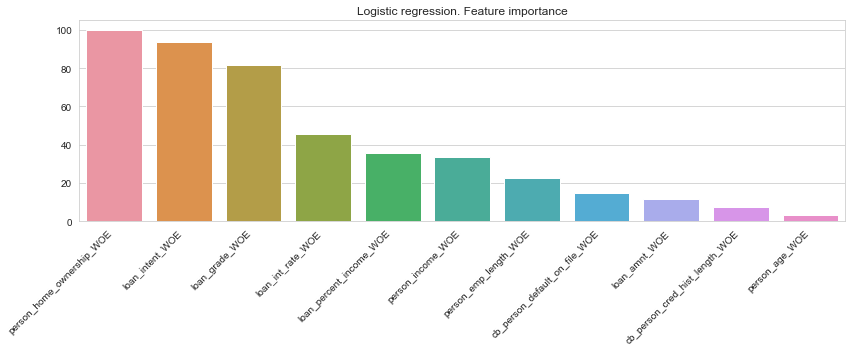

In [100]:
# calculate importances based on coefficients.
importances = abs(logreg_opt.coef_[0])
importances = 100.0 * (importances / importances.max())
# sort 
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [train_woe.columns[i] for i in indices]

# visualize
plt.figure(figsize = (12, 5))
sns.set_style("whitegrid")
chart = sns.barplot(x = names, y = importances[indices])
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light'  
)
plt.title('Logistic regression. Feature importance')
plt.tight_layout()

# Random Forest

In [101]:
rfr_opt = RandomForestClassifier(n_estimators= 100,
                                 criterion='gini',
                                 min_samples_split= 2,
                                 min_samples_leaf= 3,
                                 max_features= 'sqrt',
                                 max_depth= 4,
                                 bootstrap= False, random_state=42)

In [102]:
rfr_opt.fit(train_woe, y_train)

RandomForestClassifier(bootstrap=False, max_depth=4, max_features='sqrt',
                       min_samples_leaf=3, random_state=42)

In [103]:
test_pred = rfr_opt.predict(validate_woe)
train_pred = rfr_opt.predict(train_woe)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
Accuracy: 0.8043184885290149
AUC: 0.572998352198684
__________________________________
Train set evaluation:
_____________________________________
Accuracy: 0.8801214691988817
AUC: 0.7436518873573736
__________________________________


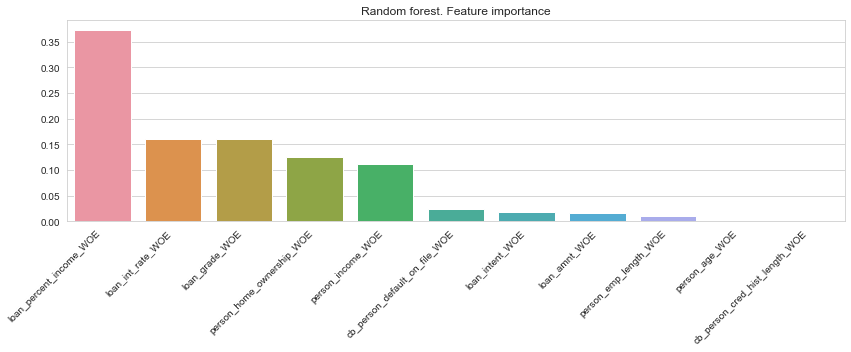

In [104]:
# Calculate feature importances
importances = rfr_opt.feature_importances_

# Visualize Feature Importance
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [train_woe.columns[i] for i in indices]

plt.figure(figsize = (12, 5))
sns.set_style("whitegrid")
chart = sns.barplot(x = names, y=importances[indices])
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light'  
)
plt.title('Random forest. Feature importance')
plt.tight_layout()

In [105]:
index = pd.MultiIndex.from_product([['Train', 'Valid'], ['Accuracy', 'AUC']])
result_rfr_opt = pd.DataFrame([pd.DataFrame({'Train' : list(evaluate(y_train, train_pred)),
             'Valid' : list(evaluate(y_test, test_pred))}).unstack().values], columns=index)
result_rfr_opt.insert(loc=0, column='Model', value = 'RF OPT')
result_rfr_opt

Model     Train               Valid          
           Accuracy       AUC  Accuracy       AUC
0  RF OPT  0.880121  0.743652  0.804318  0.572998

# XGBoost

In [106]:
train_woe_cat = X_train[['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'person_home_ownership_WOE', 'loan_intent_WOE', 'loan_grade_WOE', 'cb_person_default_on_file_WOE']]
validate_woe_cat = X_test[['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'person_home_ownership_WOE', 'loan_intent_WOE', 'loan_grade_WOE', 'cb_person_default_on_file_WOE']]

In [107]:
xgb_opt =  XGBClassifier(n_estimators = 1000,
                               max_depth = 10,
                               learning_rate = 0.01,
                               gamma = 5,
                               min_child_weight = 3,
                               subsample = 0.5,
                               random_state = 64)

In [108]:
# Training using raw data for continuous variable
xgb_opt.fit(train_woe_cat, y_train)
#xgb_opt.fit(train_woe, train_y)

[13:31:26] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=10,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=64,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [109]:
test_pred = xgb_opt.predict(validate_woe_cat)
train_pred = xgb_opt.predict(train_woe_cat)
#test_pred = xgb_opt.predict(validate_woe)
#train_pred = xgb_opt.predict(train_woe)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Test set evaluation:
_____________________________________
Accuracy: 0.8249469828417196
AUC: 0.6692686131544087
__________________________________
Train set evaluation:
_____________________________________
Accuracy: 0.937819338667695
AUC: 0.868608503361098
__________________________________


In [110]:
index = pd.MultiIndex.from_product([['Train', 'Valid'], ['Accuracy', 'AUC']])
result_xgb_opt = pd.DataFrame([pd.DataFrame({'Train' : list(evaluate(y_train, train_pred)),
             'Valid' : list(evaluate(y_test, test_pred))}).unstack().values], columns=index)
result_xgb_opt.insert(loc=0, column='Model', value = 'XGB OPT')
result_xgb_opt

Model     Train               Valid          
            Accuracy       AUC  Accuracy       AUC
0  XGB OPT  0.937819  0.868609  0.824947  0.669269

# Model Evaluation

In [111]:
result_all = pd.concat([result_logreg_opt, result_rfr_opt, result_xgb_opt], axis=0)
result_all

Model     Train               Valid          
               Accuracy       AUC  Accuracy       AUC
0  LogReg OPT  0.855056  0.747492  0.832080  0.694062
0      RF OPT  0.880121  0.743652  0.804318  0.572998
0     XGB OPT  0.937819  0.868609  0.824947  0.669269

I decided to use logistic regression to test the holdout dataset because it got the highest AUC with basic parameter and a white box model. But before test it, i will try hyperparameter optimization

## Hyperparam Optimization

In [112]:
logreg = LogisticRegression(
    random_state=42,
    solver="liblinear",
)

In [113]:
param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20),
    'max_iter' : [100, 1000,2500, 5000]
    }
]

In [114]:
clf = GridSearchCV(logreg, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)
best_clf = clf.fit(train_woe, y_train)

Fitting 3 folds for each of 320 candidates, totalling 960 fits


In [115]:
best_clf.best_estimator_

LogisticRegression(C=11.288378916846883, penalty='l1', random_state=42,
                   solver='liblinear')

# Train LogReg with new parameters

In [116]:
logreg_opt =  LogisticRegression(solver = 'liblinear',
                                 C = 11.288378916846883,
                                 penalty = 'l1',
                                 random_state = 42,
                                 n_jobs = -1)
logreg_opt.fit(train_woe, y_train)

LogisticRegression(C=11.288378916846883, n_jobs=-1, penalty='l1',
                   random_state=42, solver='liblinear')

In [117]:
holdout_woe = holdout[['cb_person_default_on_file_WOE', 'loan_grade_WOE', 'loan_intent_WOE', 'person_home_ownership_WOE', 'loan_int_rate_WOE', 'loan_percent_income_WOE', 'person_income_WOE', 'person_emp_length_WOE', 'cb_person_cred_hist_length_WOE', 'loan_amnt_WOE', 'person_age_WOE']]

In [118]:
holdout_pred = logreg_opt.predict(holdout_woe)
train_pred = logreg_opt.predict(train_woe)

print('Holdout set evaluation:\n_____________________________________')
print_evaluate(holdout['loan_status'], holdout_pred)
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

Holdout set evaluation:
_____________________________________
Accuracy: 0.7572111676692889
AUC: 0.6536761686114084
__________________________________
Train set evaluation:
_____________________________________
Accuracy: 0.8597801985924998
AUC: 0.74671350942589
__________________________________


The AUC result from holdout set is not far away from test AUC. Therefore we can say this model is generalized enough for this case